# Problem 1:
Forecast the Airlines Passengers data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

## 1. Import necessary libraries

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# ACF and PACF plots.
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
# Time series decomposition plot.
from statsmodels.tsa.seasonal import seasonal_decompose


from datetime import datetime as dt
import numpy as np
import itertools

# Linear model
import statsmodels.formula.api as smf

# Smoothing based models
## Simple exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
## Holt model
from statsmodels.tsa.holtwinters import Holt
## Holts winter exponential smoothing with multiplicative seasonality and additive trend
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # three levels of smoothening

# ARMA model
from statsmodels.tsa.arima_model import ARMA
# ARIMA model
from statsmodels.tsa.arima_model import ARIMA

# Evaluation metrics
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib notebook

## 2. Load data

In [4]:
airlines_df = pd.read_excel('Airlines+Data.xlsx', index_col=0, squeeze=True)

In [5]:
airlines_df.head()

Month
1995-01-01    112
1995-02-01    118
1995-03-01    132
1995-04-01    129
1995-05-01    121
Name: Passengers, dtype: int64

In [6]:
airlines_df.tail()

Month
2002-08-01    405
2002-09-01    355
2002-10-01    306
2002-11-01    271
2002-12-01    306
Name: Passengers, dtype: int64

In [7]:
airlines_df1 = pd.read_excel('Airlines+Data.xlsx')

In [8]:
airlines_df1.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


## 3. EDA

### 3.1 Data understanding

In [9]:
airlines_df.shape

(96,)

In [10]:
airlines_df.dtypes

dtype('int64')

### 3.2 Visualizations - Line plot and histogram

<IPython.core.display.Javascript object>


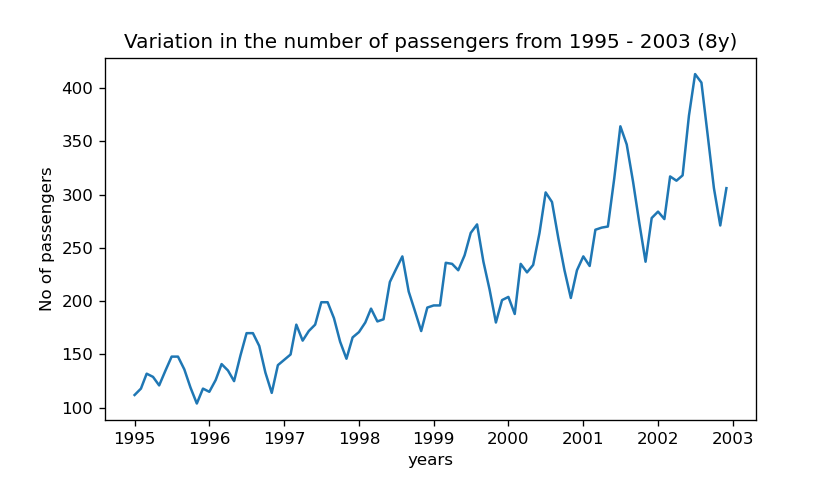

In [11]:
fig, ax = plt.subplots()
ax.plot(airlines_df)
ax.set_xlabel('years')
ax.set_ylabel('No of passengers')
ax.set_title('Variation in the number of passengers from 1995 - 2003 (8y)')
plt.show()

<IPython.core.display.Javascript object>


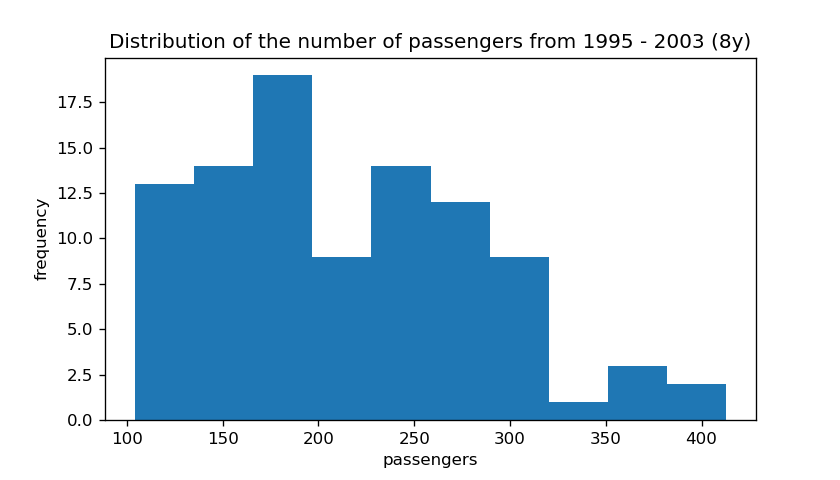

In [12]:
fig, ax = plt.subplots()
ax.hist(airlines_df)
ax.set_xlabel('passengers')
ax.set_ylabel('frequency')
ax.set_title('Distribution of the number of passengers from 1995 - 2003 (8y)')
plt.show()

In [13]:
# Summary statistics.
airlines_df.describe()

count     96.000000
mean     213.708333
std       71.918216
min      104.000000
25%      156.000000
50%      200.000000
75%      264.750000
max      413.000000
Name: Passengers, dtype: float64

### 3.3 Creating dummy variables for model building

In [14]:
airlines_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [15]:
airlines_df1['log_Passengers'] = airlines_df1['Passengers'].apply(lambda x:np.log(x))

In [16]:
# Extract month names.
airlines_df1['month_name'] = airlines_df1['Month'].dt.strftime('%b')

In [17]:
airlines_df1['year'] = airlines_df1['Month'].dt.strftime('%Y')

In [18]:
airlines_df1.head()

,Month,Passengers,log_Passengers,month_name,year
0,1995-01-01,112,4.718499,Jan,1995
1,1995-02-01,118,4.770685,Feb,1995
2,1995-03-01,132,4.882802,Mar,1995
3,1995-04-01,129,4.859812,Apr,1995
4,1995-05-01,121,4.795791,May,1995


In [19]:
month_names = airlines_df1['month_name'].unique()

In [20]:
month_enc = pd.get_dummies(airlines_df1['month_name']).reindex(columns=month_names)

In [21]:
month_enc

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
91,0,0,0,0,0,0,0,1,0,0,0,0
92,0,0,0,0,0,0,0,0,1,0,0,0
93,0,0,0,0,0,0,0,0,0,1,0,0
94,0,0,0,0,0,0,0,0,0,0,1,0


In [22]:
# Creating a numeric column fot time in months.
t_array = np.linspace(1,len(airlines_df1), num=len(airlines_df1), dtype=int)
t_sq_array = t_array**2

In [23]:
time = {'t':t_array,
       't_square':t_sq_array}

In [24]:
t_df = pd.DataFrame(time, index=airlines_df1.index)

In [25]:
airlines_df2 = pd.concat([airlines_df1, t_df, month_enc], axis=1)

In [26]:
airlines_df2.head()

,Month,Passengers,log_Passengers,month_name,year,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1995-01-01,112,4.718499,Jan,1995,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1,1995-02-01,118,4.770685,Feb,1995,2,4,0,1,0,0,0,0,0,0,0,0,0,0
2,1995-03-01,132,4.882802,Mar,1995,3,9,0,0,1,0,0,0,0,0,0,0,0,0
3,1995-04-01,129,4.859812,Apr,1995,4,16,0,0,0,1,0,0,0,0,0,0,0,0
4,1995-05-01,121,4.795791,May,1995,5,25,0,0,0,0,1,0,0,0,0,0,0,0


In [27]:
# Crosstab to generate heatmaps
airlines_pivot = pd.pivot_table(data=airlines_df2, values='Passengers', index='year', columns='month_name')

In [28]:
airlines_pivot

month_name,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
year,,,,,,,,,,,,
1995,129,148,118,118,112,148,135,132,121,104,119,136
1996,135,170,140,126,115,170,149,141,125,114,133,158
1997,163,199,166,150,145,199,178,178,172,146,162,184
1998,181,242,194,180,171,230,218,193,183,172,191,209
1999,235,272,201,196,196,264,243,236,229,180,211,237
2000,227,293,229,188,204,302,264,235,234,203,229,259
2001,269,347,278,233,242,364,315,267,270,237,274,312
2002,313,405,306,277,284,413,374,317,318,271,306,355


### 3.3 Visualizations - Heatmap and boxplots

<IPython.core.display.Javascript object>


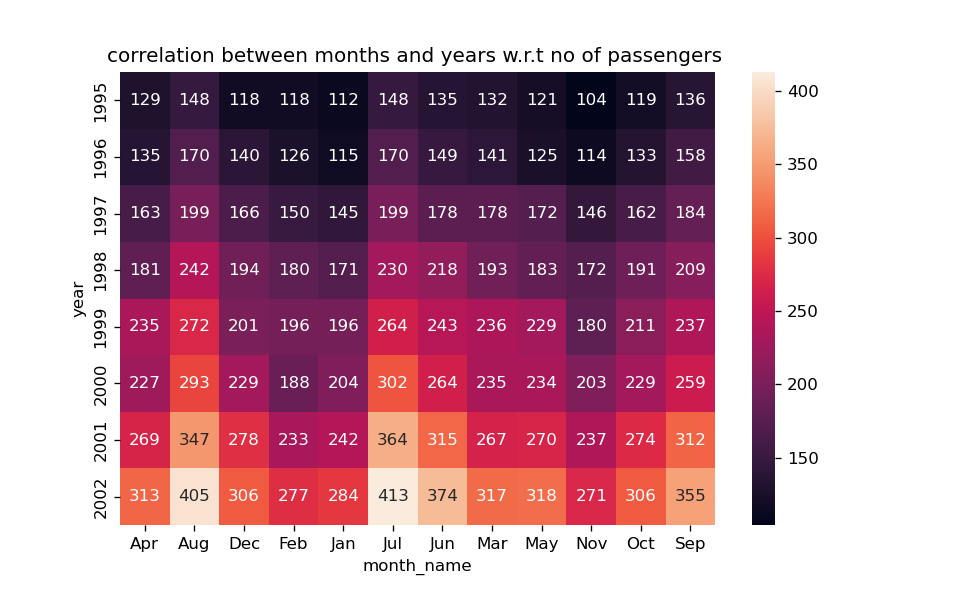

Text(0.5, 1.0, 'correlation between months and years w.r.t no of passengers ')

In [29]:
# Heatmap
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(data=airlines_pivot, annot=True, fmt='g', ax=ax)
ax.set_title('correlation between months and years w.r.t no of passengers ')

<IPython.core.display.Javascript object>


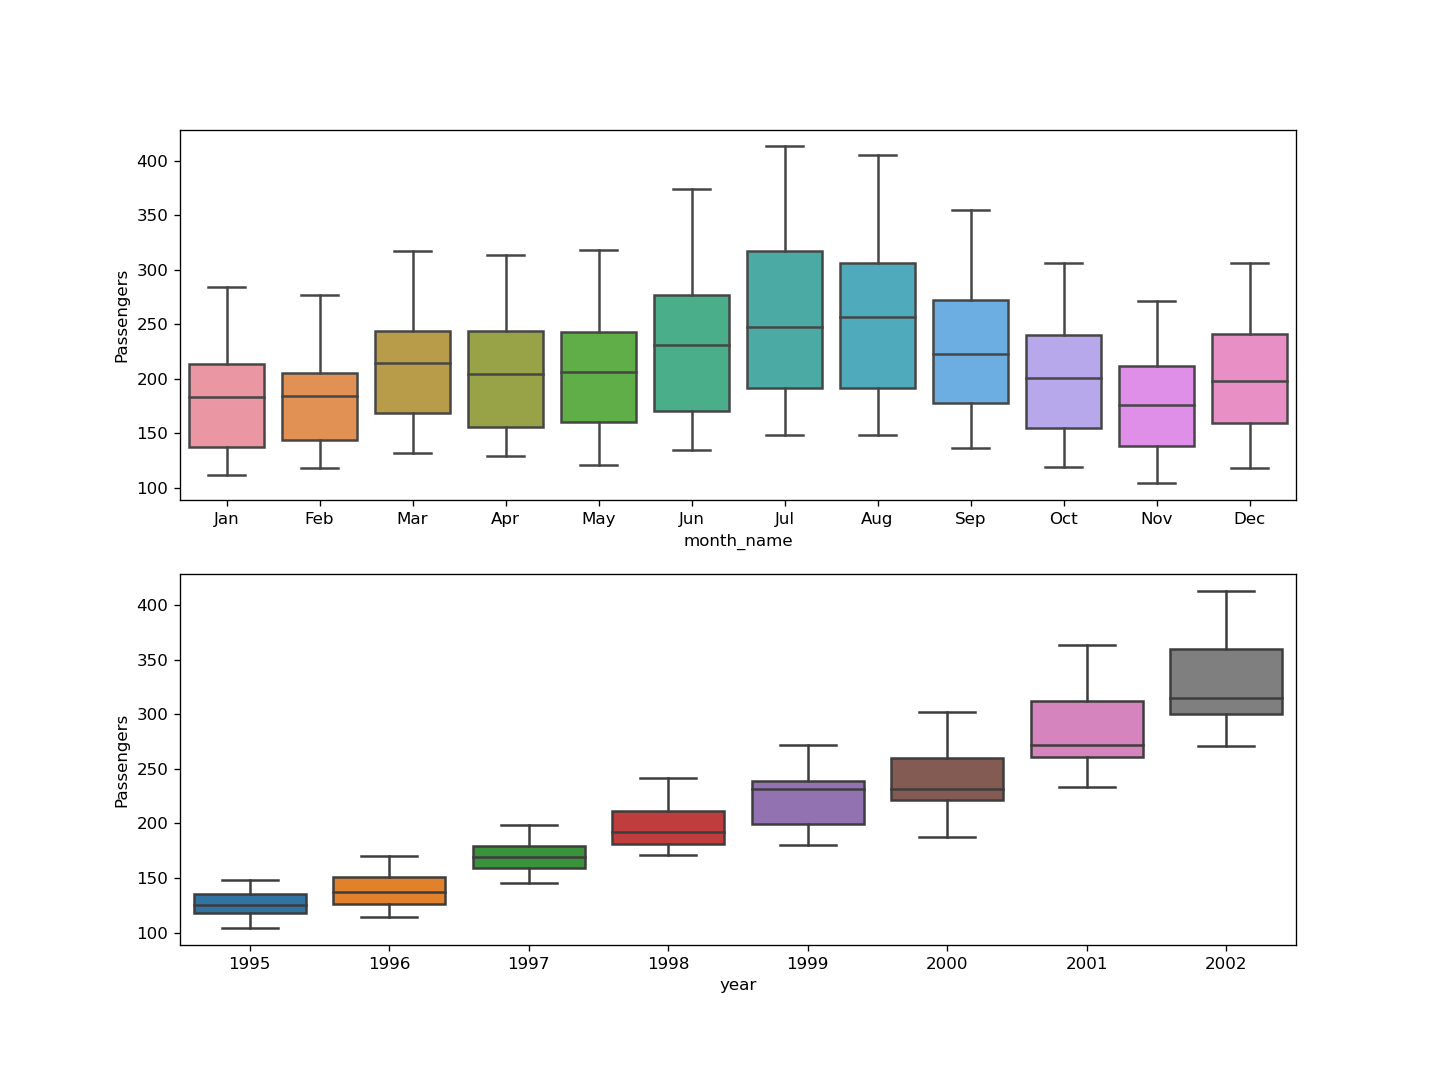

<AxesSubplot:xlabel='year', ylabel='Passengers'>

In [30]:
## Boxplot
fig, ax = plt.subplots(2, 1 ,figsize=(12,9))
sns.boxplot(x='month_name', y='Passengers', data=airlines_df2, ax=ax[0])
sns.boxplot(x='year', y='Passengers', data=airlines_df2, ax=ax[1])

### 3.4 Visualizing the trend with line plot

<IPython.core.display.Javascript object>


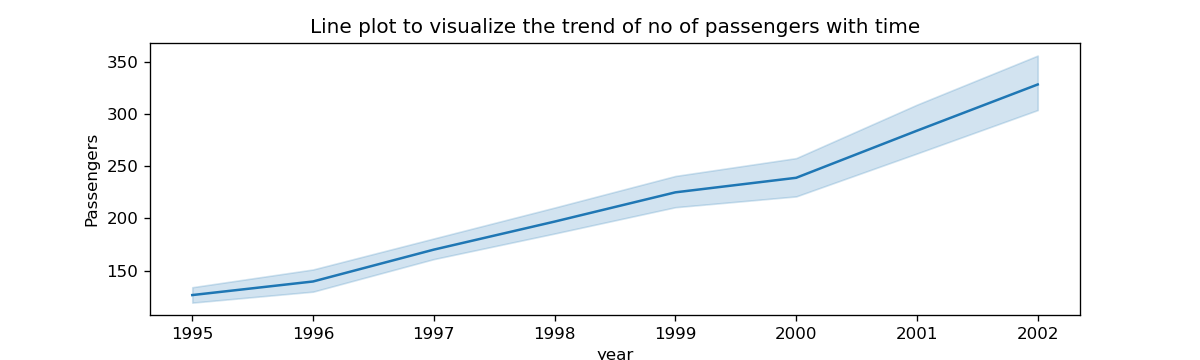

In [31]:
fig, ax = plt.subplots(figsize=(10,3))
sns.lineplot(x='year', y='Passengers', data=airlines_df2, ax=ax)
ax.set_title('Line plot to visualize the trend of no of passengers with time')
plt.show()

### 3.5 Lag plot
Visualizing relationship of previous month's number with next months number of passengers

<IPython.core.display.Javascript object>


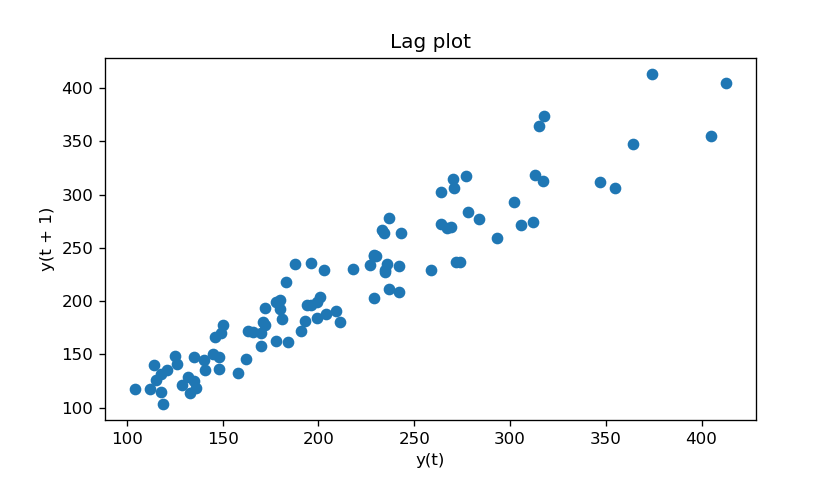

In [32]:
fig, ax = plt.subplots()
pd.plotting.lag_plot(airlines_df2['Passengers'], ax=ax)
ax.set_title('Lag plot')
plt.show()

**Observations**: The linear trend indicates that there is a relationship between previous month's passenger count with the next month's count 

### 3.6 Time series decomposition plot

<IPython.core.display.Javascript object>


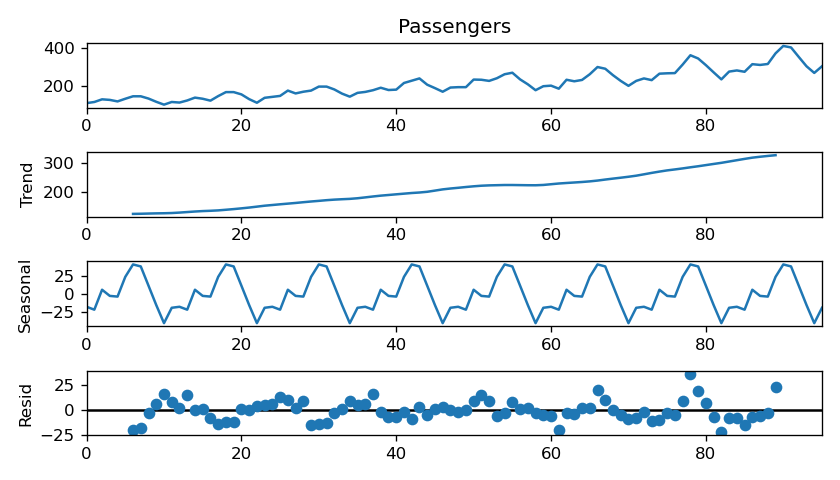

In [33]:
decompose_ts_add = seasonal_decompose(airlines_df2['Passengers'],period=12)
decompose_ts_add.plot()
plt.show()

### 3.7 Observations:
- Original dataset: 96 records and two columns, no null values.
- Need to forecast the number of passengers  for the next 12 months.
- From the line plots, we see a linear growth and a periodic pattern in the fluctuations with growing amplitudes, suggesting a multiplicative seasonality like pattern.
- The mean and variance of the number of passengers changes every year.
- From the histogram and summary statistics, we see that he number of passengers vary between 104 to 413 with an average of ~ 214 passengers. Since the mean and variance changes with time, we cannot give the last month's number as the next month's number i.e we cannot make a naive forecast.
- From the heatmap, and the monthwise boxplot, we see that the number of passengers is relatively higher in the months August, Jul, June, September.
- From the yearwise boxplot, we see that the overall number of passengers that travel in the airlines has been increasing over the years.

## 4. Model based forecasting 

### 4.1 Model Building

In [34]:
airlines_df2.head()

,Month,Passengers,log_Passengers,month_name,year,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1995-01-01,112,4.718499,Jan,1995,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1,1995-02-01,118,4.770685,Feb,1995,2,4,0,1,0,0,0,0,0,0,0,0,0,0
2,1995-03-01,132,4.882802,Mar,1995,3,9,0,0,1,0,0,0,0,0,0,0,0,0
3,1995-04-01,129,4.859812,Apr,1995,4,16,0,0,0,1,0,0,0,0,0,0,0,0
4,1995-05-01,121,4.795791,May,1995,5,25,0,0,0,0,1,0,0,0,0,0,0,0


In [35]:
airlines_df2.shape

(96, 19)

In [36]:
train_data = airlines_df2.iloc[:84, :]

In [37]:
train_data.tail()

,Month,Passengers,log_Passengers,month_name,year,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
79,2001-08-01,347,5.849325,Aug,2001,80,6400,0,0,0,0,0,0,0,1,0,0,0,0
80,2001-09-01,312,5.743003,Sep,2001,81,6561,0,0,0,0,0,0,0,0,1,0,0,0
81,2001-10-01,274,5.613128,Oct,2001,82,6724,0,0,0,0,0,0,0,0,0,1,0,0
82,2001-11-01,237,5.468060,Nov,2001,83,6889,0,0,0,0,0,0,0,0,0,0,1,0
83,2001-12-01,278,5.627621,Dec,2001,84,7056,0,0,0,0,0,0,0,0,0,0,0,1


In [38]:
test_data = airlines_df2.iloc[84:, :]

In [39]:
test_data

,Month,Passengers,log_Passengers,month_name,year,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
84,2002-01-01,284,5.648974,Jan,2002,85,7225,1,0,0,0,0,0,0,0,0,0,0,0
85,2002-02-01,277,5.624018,Feb,2002,86,7396,0,1,0,0,0,0,0,0,0,0,0,0
86,2002-03-01,317,5.758902,Mar,2002,87,7569,0,0,1,0,0,0,0,0,0,0,0,0
87,2002-04-01,313,5.746203,Apr,2002,88,7744,0,0,0,1,0,0,0,0,0,0,0,0
88,2002-05-01,318,5.762051,May,2002,89,7921,0,0,0,0,1,0,0,0,0,0,0,0
89,2002-06-01,374,5.924256,Jun,2002,90,8100,0,0,0,0,0,1,0,0,0,0,0,0
90,2002-07-01,413,6.023448,Jul,2002,91,8281,0,0,0,0,0,0,1,0,0,0,0,0
91,2002-08-01,405,6.003887,Aug,2002,92,8464,0,0,0,0,0,0,0,1,0,0,0,0
92,2002-09-01,355,5.872118,Sep,2002,93,8649,0,0,0,0,0,0,0,0,1,0,0,0
93,2002-10-01,306,5.723585,Oct,2002,94,8836,0,0,0,0,0,0,0,0,0,1,0,0


In [40]:
# Function to construct formula for ols
def formula_constructor(predict_col, feature_names):
    formula = predict_col + '~'
    for i in range(len(feature_names)):
        if i == 0:
            formula += feature_names[i]
        else:
            formula += ('+' + feature_names[i])
    return formula

In [41]:
# Function to train and test different time series models.
def time_series_model(train_data, test_data, feature_names, predict_col, log_predict_col=None, exp=False, model_name=None, disp_results=False):
    
    if exp == True:
        # Training
        formula = formula_constructor(log_predict_col, feature_names)
        model = smf.ols(formula, data=train_data).fit()
        preds = pd.Series(model.predict(pd.DataFrame(test_data[feature_names])))
        # Evaluation:
        rmse = np.sqrt(np.mean((np.array(test_data[predict_col]) - np.array(np.exp(preds)))**2))
    else:
        # Training
        formula = formula_constructor(predict_col, feature_names)
        model = smf.ols(formula, data=train_data).fit() 
        preds = pd.Series(model.predict(pd.DataFrame(test_data[feature_names])))
        # Evaluation:
        rmse = np.sqrt(np.mean((np.array(test_data[predict_col]) - np.array(preds))**2))
    
    if disp_results == True: 
        print("Formula used for {} model: {}".format(model_name, formula))
        print("RMSE for {} model        : {:.3f}".format(model_name, rmse))
        return rmse
    else:
        return rmse

#### 4.1.1 Linear model:

In [42]:
lin_mod = time_series_model(train_data=train_data,
                            test_data=test_data,
                            feature_names='t',
                            predict_col='Passengers',
                            exp=False,
                            model_name='linear',
                            disp_results=True)

Formula used for linear model: Passengers~t
RMSE for linear model        : 53.199


#### 4.1.2 Exponential model:

In [43]:
exp_model = time_series_model(train_data=train_data,
                              test_data=test_data,
                              feature_names='t',
                              predict_col='Passengers',
                              log_predict_col='log_Passengers',
                              exp=True,
                              model_name='exponential',
                              disp_results=True)

Formula used for exponential model: log_Passengers~t
RMSE for exponential model        : 46.057


#### 4.1.3 Quadratic model:

In [44]:
quad_model = time_series_model(train_data=train_data,
                               test_data=test_data,
                               feature_names=['t', 't_square'],
                               predict_col='Passengers',
                               log_predict_col=None,
                               exp=False,
                               model_name='quadratic',
                               disp_results=True)

Formula used for quadratic model: Passengers~t+t_square
RMSE for quadratic model        : 48.052


#### 4.1.4 Additive seasonality

In [45]:
add_sea = time_series_model(train_data=train_data,
                            test_data=test_data,
                            feature_names=['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec'],
                            predict_col='Passengers',
                            log_predict_col=None,
                            exp=False,
                            model_name='additive seasonality',
                            disp_results=True)

Formula used for additive seasonality model: Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec
RMSE for additive seasonality model        : 132.820


#### 4.1.5 Additive seasonality quadratic

In [46]:
add_sea_quad = time_series_model(train_data=train_data,
                                test_data=test_data,
                                feature_names=['t', 't_square', 'Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec'],
                                predict_col='Passengers',
                                log_predict_col=None,
                                exp=False,
                                model_name='additive seasonality quadratic',
                                disp_results=True)

Formula used for additive seasonality quadratic model: Passengers~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec
RMSE for additive seasonality quadratic model        : 26.361


#### 4.1.6 Multiplicative seasonality:

In [47]:
mul_sea = time_series_model(train_data=train_data,
                            test_data=test_data,
                            feature_names=['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec'],
                            predict_col='Passengers',
                            log_predict_col='log_Passengers',
                            exp=True,
                            model_name='multiplicative seasonality',
                            disp_results=True) 

Formula used for multiplicative seasonality model: log_Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec
RMSE for multiplicative seasonality model        : 140.063


### 4.2 Compare the results

In [48]:
summary = {'Model RMSE':pd.Series(['linear', 'exponential', 'quadratic', 'add_seasonality', 'add_seasonality_quad', 'mul_seasonality']),
           'RMSE values':pd.Series([lin_mod, exp_model, quad_model, add_sea, add_sea_quad, mul_sea])}
table_rmse = pd.DataFrame(summary).sort_values(['RMSE values']).reset_index(drop=True)


In [49]:
table_rmse

,Model RMSE,RMSE values
0,add_seasonality_quad,26.360818
1,exponential,46.057361
2,quadratic,48.051889
3,linear,53.199237
4,add_seasonality,132.819785
5,mul_seasonality,140.063202


### 4.3 Observations:
- From the above analysis, we see that 'additive seasonality with quadratic trend' has the least RMSE od all the models, thus we can use it for forecasting.
- 17 dummy variables were created for providing a forecast on the airlines' potential number of passengers.

### 4.4 Model fitting and verification

In [50]:
feature_cols = ['t', 't_square', 'Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']
predict_col = 'Passengers'

In [51]:
formula = formula_constructor(predict_col, feature_cols)
add_seaq_model = smf.ols(formula, data=train_data).fit() 

In [52]:
test_data1 = test_data.copy() # To use for predictions

In [53]:
test_data1 = test_data1.drop(['Passengers', 'log_Passengers'], axis=1)

In [54]:
test_data1['F_Passengers'] = pd.Series(add_seaq_model.predict(pd.DataFrame(test_data[feature_cols]))).round().astype('int')

In [55]:
test_data1.head()

,Month,month_name,year,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,F_Passengers
84,2002-01-01,Jan,2002,85,7225,1,0,0,0,0,0,0,0,0,0,0,0,282
85,2002-02-01,Feb,2002,86,7396,0,1,0,0,0,0,0,0,0,0,0,0,284
86,2002-03-01,Mar,2002,87,7569,0,0,1,0,0,0,0,0,0,0,0,0,312
87,2002-04-01,Apr,2002,88,7744,0,0,0,1,0,0,0,0,0,0,0,0,306
88,2002-05-01,May,2002,89,7921,0,0,0,0,1,0,0,0,0,0,0,0,306


### 4.5 Visualizing the sequential prediction

In [56]:
train_data1 = train_data.copy() # To use for visualizations

In [57]:
airlines_forecast = pd.concat([train_data1, test_data1], axis=0)

In [58]:
airlines_forecast.tail()

,Month,Passengers,log_Passengers,month_name,year,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,F_Passengers
91,2002-08-01,NaN,NaN,Aug,2002,92,8464,0,0,0,0,0,0,0,1,0,0,0,0,357.0
92,2002-09-01,NaN,NaN,Sep,2002,93,8649,0,0,0,0,0,0,0,0,1,0,0,0,332.0
93,2002-10-01,NaN,NaN,Oct,2002,94,8836,0,0,0,0,0,0,0,0,0,1,0,0,308.0
94,2002-11-01,NaN,NaN,Nov,2002,95,9025,0,0,0,0,0,0,0,0,0,0,1,0,285.0
95,2002-12-01,NaN,NaN,Dec,2002,96,9216,0,0,0,0,0,0,0,0,0,0,0,1,310.0


In [59]:
airlines_forecast_vis = airlines_forecast[['Passengers', 'F_Passengers']]

In [60]:
airlines_forecast_vis.tail()

,Passengers,F_Passengers
91,NaN,357.0
92,NaN,332.0
93,NaN,308.0
94,NaN,285.0
95,NaN,310.0


<IPython.core.display.Javascript object>


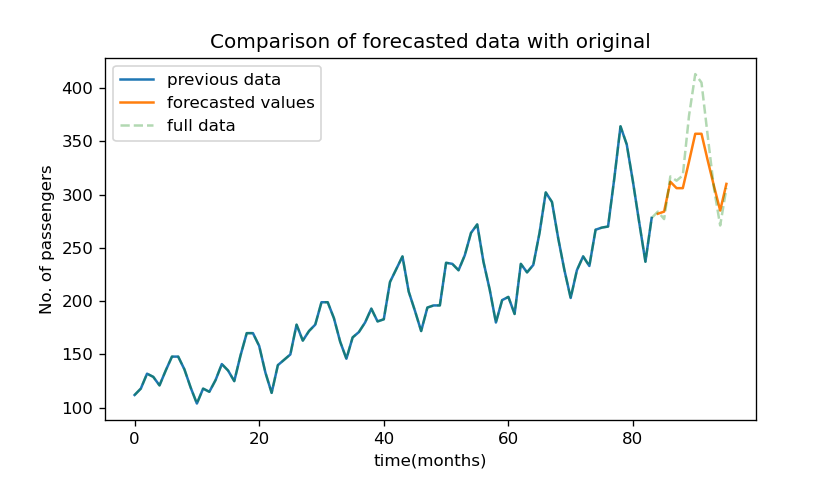

In [61]:
fig, ax = plt.subplots()
ax.plot(airlines_forecast_vis, label=['previous data','forecasted values'])
ax.plot(range(len(airlines_forecast_vis)), airlines_df2['Passengers'], 'g--', label='full data', alpha=0.3)
ax.set_xlabel('time(months)')
ax.set_ylabel('No. of passengers')
ax.set_title('Comparison of forecasted data with original')
ax.legend()
plt.show()

## 5. Data driven forecasting

### 5.1 Models based on smoothing 

#### 5.1.1 Moving average

In [62]:
airlines_df2.head()

,Month,Passengers,log_Passengers,month_name,year,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1995-01-01,112,4.718499,Jan,1995,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1,1995-02-01,118,4.770685,Feb,1995,2,4,0,1,0,0,0,0,0,0,0,0,0,0
2,1995-03-01,132,4.882802,Mar,1995,3,9,0,0,1,0,0,0,0,0,0,0,0,0
3,1995-04-01,129,4.859812,Apr,1995,4,16,0,0,0,1,0,0,0,0,0,0,0,0
4,1995-05-01,121,4.795791,May,1995,5,25,0,0,0,0,1,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>


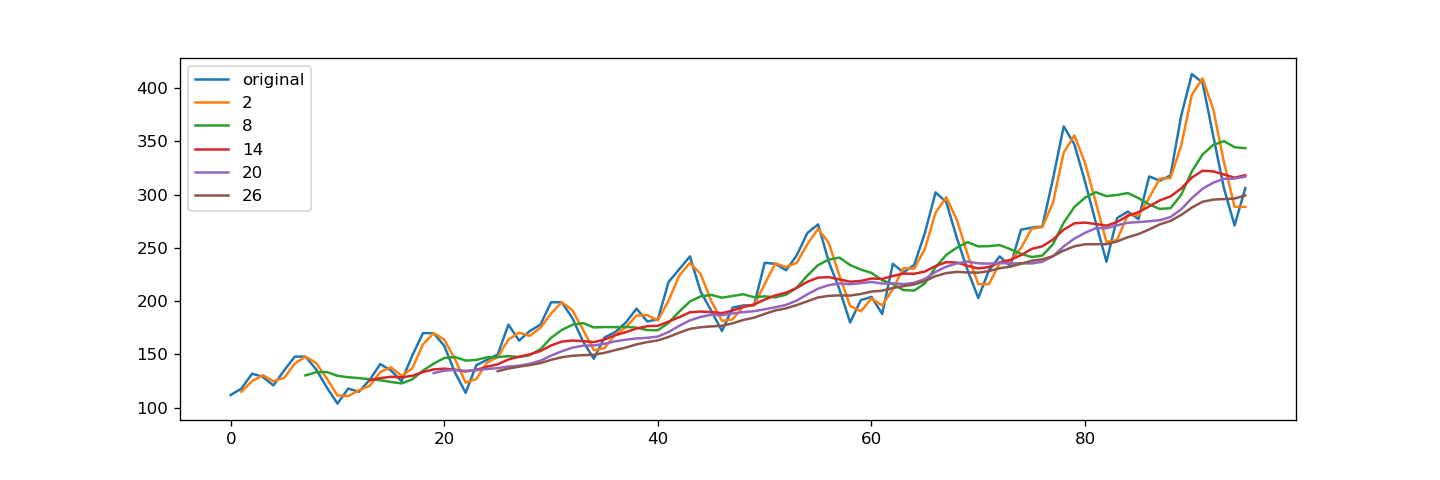

In [63]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(airlines_df2['Passengers'], label="original") 
for i in range(2,30,6):
    ax.plot(airlines_df2['Passengers'].rolling(i).mean(), label=str(i))
ax.legend(loc='best')
plt.show()

**Observations**: Curve correspinding to 26 (brown color) nearly touches the end of the original curve. THis curve is suitable if we want to use the moving average for forecasting. This technique may not give the best results.

#### 5.1.2 Simple exponential smoothing model

In [64]:
# forcast -  based on current time
ses_model = SimpleExpSmoothing(train_data["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test_data.index[0],end = test_data.index[-1])

ses_mape=mean_absolute_percentage_error(pred_ses,test_data['Passengers'])*100 
print("MAPE for simple exp smoothing: {:.3f}".format(ses_mape))

MAPE for simple exp smoothing: 17.236


#### 5.1.3 Holt model

In [65]:
# forcast - based on current time, trend
hw_model = Holt(train_data["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2) # two levels of smoothening
pred_hw = hw_model.predict(start = test_data.index[0],end = test_data.index[-1])
hw_mape=mean_absolute_percentage_error(pred_hw,test_data['Passengers'])*100
print("MAPE for Holt model: {:.3f}".format(hw_mape))

MAPE for Holt model: 33.788


#### 5.1.4 Holt winter exponential smoothing with multiplicative seasonality and additive trend.

In [66]:
# forcast - based on current time, trend, seasonality
hwe_model_mul_add = ExponentialSmoothing(train_data["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test_data.index[0],end = test_data.index[-1])

hw_ma_mape=mean_absolute_percentage_error(pred_hwe_mul_add,test_data['Passengers'])*100 
print("MAPE for HW exp smoothing with mul seasonality and add trend model: {:.3f}".format(hw_ma_mape))


MAPE for HW exp smoothing with mul seasonality and add trend model: 2.941


#### 5.1.5 Holt winter exponential smoothing with additive seasonality and multiplicative trend.

In [67]:
# forcast - based on current time, trend, seasonality
hwe_model_add_mul = ExponentialSmoothing(train_data["Passengers"],seasonal="add",trend="mul",seasonal_periods=12).fit() 
pred_hwe_add_mul = hwe_model_add_mul.predict(start = test_data.index[0],end = test_data.index[-1])

hw_am_mape=mean_absolute_percentage_error(pred_hwe_add_mul,test_data['Passengers'])*100 
print("MAPE for HW exp smoothing with add seasonality and mul trend model: {:.3f}".format(hw_am_mape))


MAPE for HW exp smoothing with add seasonality and mul trend model: 2.100


#### 5.1.6 Holt winter exponential smoothing with additive seasonality and additive trend.

In [68]:
hwe_model_add_add = ExponentialSmoothing(train_data["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test_data.index[0],end = test_data.index[-1])

hw_aa_mape=mean_absolute_percentage_error(pred_hwe_add_add,test_data['Passengers'])*100 
print("MAPE for HW exp smoothing with add seasonality and add trend model: {:.3f}".format(hw_aa_mape))

MAPE for HW exp smoothing with add seasonality and add trend model: 6.109


In [69]:
summary_ddf = {'Model MAPE':pd.Series(['se smoothing', 'Holt model', 'HW ma', 'HW am', 'HW aa']),
           'MAPE values':pd.Series([ses_mape, hw_mape, hw_ma_mape, hw_am_mape, hw_aa_mape])}
table_mape_ddf = pd.DataFrame(summary_ddf).sort_values(['MAPE values']).reset_index(drop=True)

In [70]:
table_mape_ddf

,Model MAPE,MAPE values
0,HW am,2.100006
1,HW ma,2.941496
2,HW aa,6.109488
3,se smoothing,17.236298
4,Holt model,33.788331


Holt winter exponential smoothing with additive seasonality and multiplicative trend has the least MAPE. We will use it for forecasting.

#### 5.1.7 Final model using smoothing based forecasting techniques.

In [71]:
hw_am_model = ExponentialSmoothing(train_data["Passengers"],seasonal="add",trend="mul",seasonal_periods=12).fit()
test_data2 = test_data.copy() # To use for predictions
test_data2 = test_data2.drop(['Passengers', 'log_Passengers'], axis=1)
test_data2['F_Passengers'] = pd.Series(hw_am_model.predict(start = test_data.index[0],end = test_data.index[-1])).round().astype('int')

In [72]:
test_data2.head()

,Month,month_name,year,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,F_Passengers
84,2002-01-01,Jan,2002,85,7225,1,0,0,0,0,0,0,0,0,0,0,0,288
85,2002-02-01,Feb,2002,86,7396,0,1,0,0,0,0,0,0,0,0,0,0,279
86,2002-03-01,Mar,2002,87,7569,0,0,1,0,0,0,0,0,0,0,0,0,316
87,2002-04-01,Apr,2002,88,7744,0,0,0,1,0,0,0,0,0,0,0,0,320
88,2002-05-01,May,2002,89,7921,0,0,0,0,1,0,0,0,0,0,0,0,324


#### 5.1.8 Visualizing the predictions (smoothing based forecasting)

In [73]:
train_data2 = train_data.copy() # To use for visualizations
airlines_forecast_ddf = pd.concat([train_data2, test_data2], axis=0)

In [74]:
airlines_forecast_ddf.tail()

,Month,Passengers,log_Passengers,month_name,year,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,F_Passengers
91,2002-08-01,NaN,NaN,Aug,2002,92,8464,0,0,0,0,0,0,0,1,0,0,0,0,390.0
92,2002-09-01,NaN,NaN,Sep,2002,93,8649,0,0,0,0,0,0,0,0,1,0,0,0,353.0
93,2002-10-01,NaN,NaN,Oct,2002,94,8836,0,0,0,0,0,0,0,0,0,1,0,0,316.0
94,2002-11-01,NaN,NaN,Nov,2002,95,9025,0,0,0,0,0,0,0,0,0,0,1,0,283.0
95,2002-12-01,NaN,NaN,Dec,2002,96,9216,0,0,0,0,0,0,0,0,0,0,0,1,321.0


In [75]:
airlines_forecast_vis_ddf = airlines_forecast_ddf[['Passengers', 'F_Passengers']]

In [76]:
airlines_forecast_vis_ddf.tail()

,Passengers,F_Passengers
91,NaN,390.0
92,NaN,353.0
93,NaN,316.0
94,NaN,283.0
95,NaN,321.0


<IPython.core.display.Javascript object>


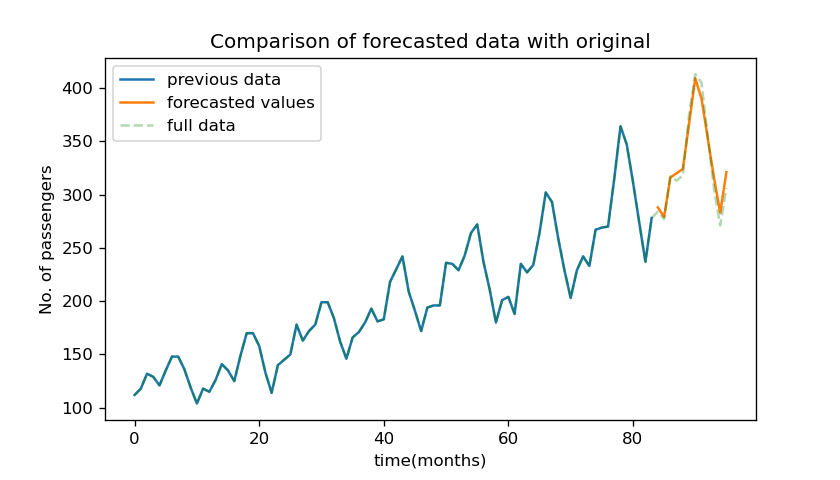

In [77]:
fig, ax = plt.subplots()
ax.plot(airlines_forecast_vis_ddf, label=['previous data','forecasted values'])
ax.plot(range(len(airlines_forecast_vis_ddf)), airlines_df2['Passengers'], 'g--', label='full data', alpha=0.3)
ax.set_xlabel('time(months)')
ax.set_ylabel('No. of passengers')
ax.set_title('Comparison of forecasted data with original')
ax.legend()
plt.show()

**Observations:** The forcasted values almost match the actual values. The chosen model is doing a good job in following the trend.

### 5.2  ARMA , ARIMA and SARIMA models

#### 5.2.1 ACF and PACF plots
ACF: plot between lags and values of correlation

PACF - partial auto-correlation function, plot between lags and residuals 
(Instead of finding correlations of present with lags like ACF, it finds correlations between the residuals)

<IPython.core.display.Javascript object>


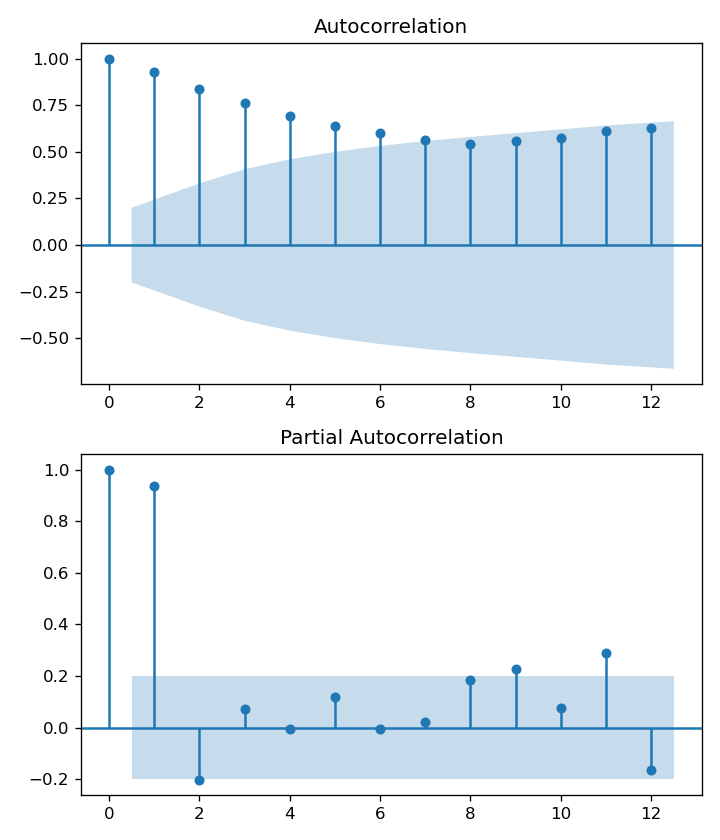

In [78]:
fig, ax = plt.subplots(2,1, figsize=(6,7))
tsa_plots.plot_acf(airlines_df2['Passengers'], lags=12, ax=ax[0])
tsa_plots.plot_pacf(airlines_df2['Passengers'], lags=12, ax=ax[1])
fig.tight_layout()
plt.show()

####  Observations.
- ACF plot: strong correlation until 12 lags and beyond.
- PACF plot: Significant correlations at the first tenth and twelfth lags -> Autoregressive term in the data. 
- SInce there is a trend in data, ARMA models may not perform well at forecasting.
- AR model with order 3 may be chosen since there are 3 significant spikes in PACF plot (First one is ignored since it corresponds to lag 0).

#### 5.2.2 ARMA

In [79]:
ARMAmodel = ARMA(train_data['Passengers'], order=(3, 0)) #model with AR=3 and MA=0
ARMAmodel_fit = ARMAmodel.fit()

ARMA_pred = ARMAmodel_fit.predict(start = test_data.index[0],end = test_data.index[-1])
ARMA_pred

arma_mape=mean_absolute_percentage_error(ARMA_pred,test_data['Passengers'])*100 
arma_mape

27.593632372238936

#### 5.2.3 ARIMA

<IPython.core.display.Javascript object>


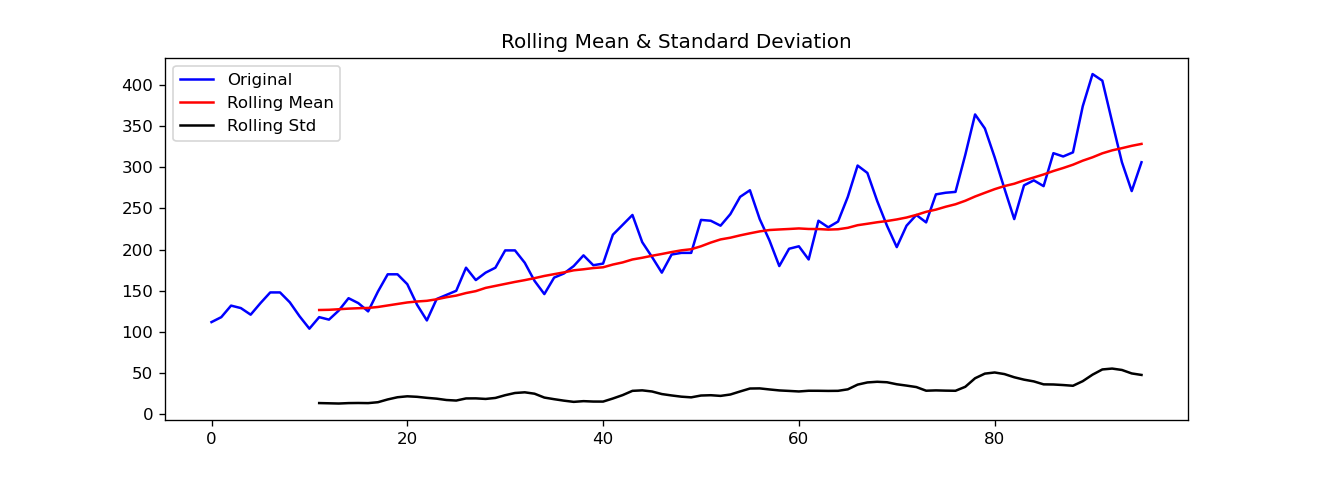

In [80]:
#  visualizing the trend/ stationary nature of data - for ARIMA model
rolLmean = airlines_df2['Passengers'].rolling(12).mean() # 12 entries
rolLstd = airlines_df2['Passengers'].rolling(12).std()

fig, ax = plt.subplots(figsize=(11,4))

#Plot rolling statistics:
orig = ax.plot(airlines_df2['Passengers'], color='blue',label='Original')
mean = ax.plot(rolLmean, color='red', label='Rolling Mean')
std = ax.plot(rolLstd, color='black', label = 'Rolling Std')
ax.legend(loc='best')
ax.set_title('Rolling Mean & Standard Deviation')
plt.show(block=False)

**Observations:** The data is not stationary, hence we cannot use ARMA and need to make it stationary and apply ARIMA.

<IPython.core.display.Javascript object>


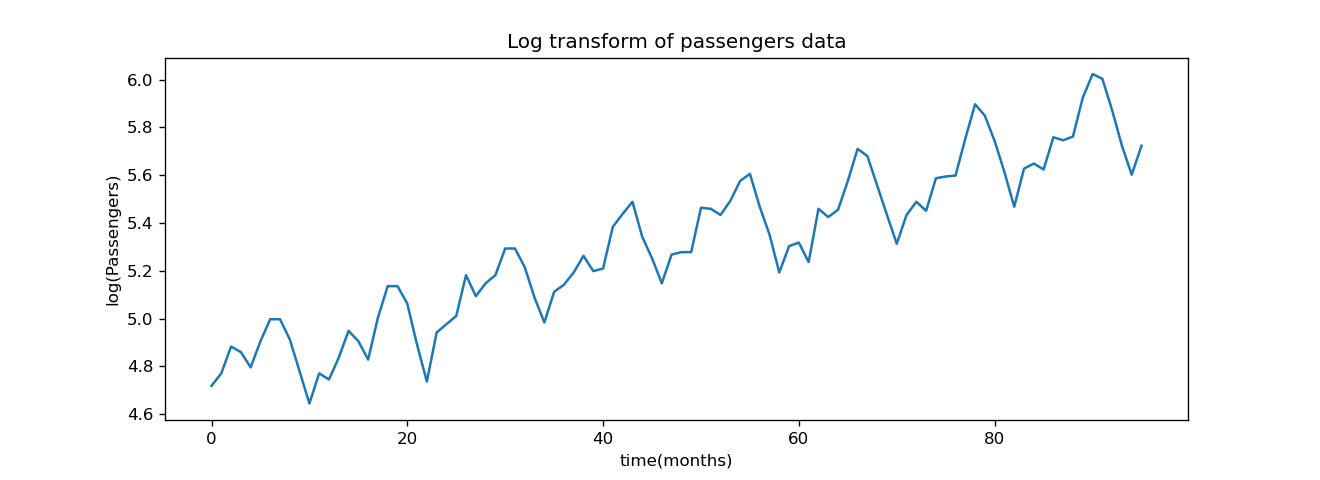

In [81]:
# Log transform 
fig, ax = plt.subplots(figsize=(11,4))

ts_log = np.log(airlines_df2['Passengers'])#to transform to stationary from non-stationary
ax.plot(ts_log)
ax.set_title('Log transform of passengers data')
ax.set_xlabel('time(months)')
ax.set_ylabel('log(Passengers)')
plt.show()

**Observations:** Log transform is not able to make the data linear.

<IPython.core.display.Javascript object>


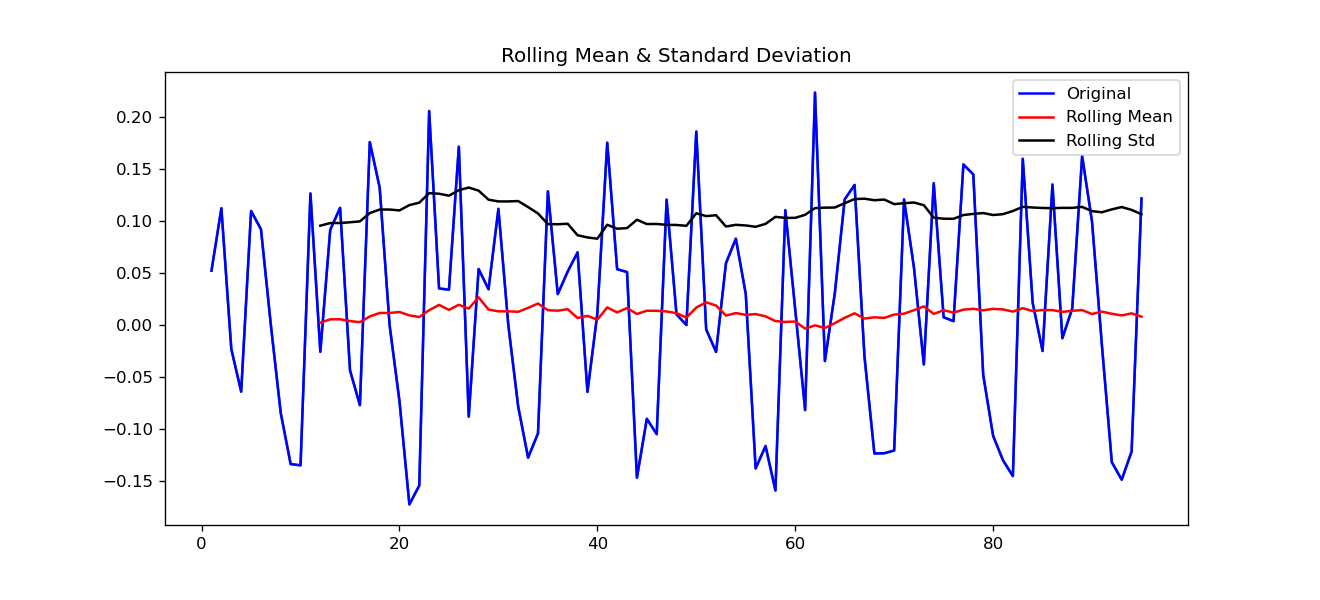

In [82]:
#  Differencing
fig, ax = plt.subplots(figsize=(11,5))

ts_log_diff = ts_log - ts_log.shift(periods=1) # shift the time series by 1 and subtract from the original TS.
ax.plot(ts_log_diff)

#Determing rolling statistics
rolLmean = ts_log_diff.rolling(12).mean()
rolLstd = ts_log_diff.rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(ts_log_diff, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
ax.legend(loc='best')
ax.set_title('Rolling Mean & Standard Deviation')
plt.show(block=False)

**Observations** The rolling maean line is somewhat flat(stationary).

In [83]:
# ACF and PACF plots for the transformed data.
lag_acf = acf(ts_log_diff, nlags=12)
lag_pacf = pacf(ts_log_diff, nlags=12)

<IPython.core.display.Javascript object>


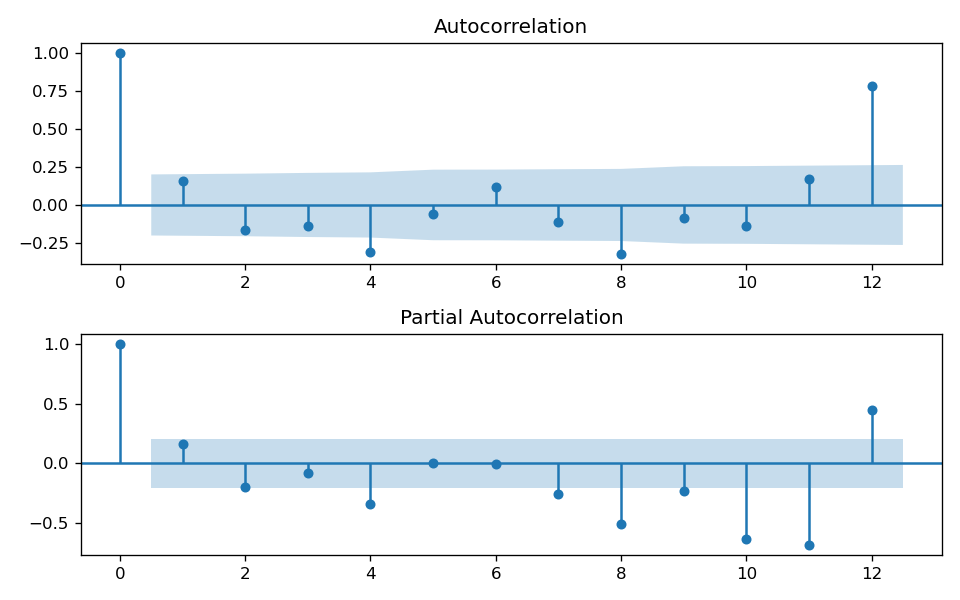

In [84]:
fig,ax = plt.subplots(2 ,1 ,figsize=(8,5))
sm.graphics.tsa.plot_acf(ts_log_diff.dropna(),lags=12,ax=ax[0])
sm.graphics.tsa.plot_pacf(ts_log_diff.dropna(),lags=12,ax=ax[1])
fig.tight_layout()
plt.show()

MA with order 4

In [85]:
p = range(0,5) #AR order
d = range(0,5) #Shift
q = range(0,5) #MA order
pdq = list(itertools.product(p,d,q))

In [86]:
pdq[:5]

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4)]

In [87]:
# Searching for best (p, d, q)
arima_params = dict.fromkeys(pdq)
for param in pdq:
    try:
        model_arima = ARIMA(train_data['Passengers'],order=param)
        model_arima_fit = model_arima.fit()
        arima_params[param] = model_arima_fit.aic
        #print(param,)
    except:
        continue

In [88]:
pdq_df1 = pd.Series(arima_params.keys(), name='pdq')
pdq_df2 = pd.Series(arima_params.values(), name='aic')
pdq_df = pd.concat([pdq_df1,pdq_df2], axis=1)
min_aic = pdq_df['aic'].min()

In [89]:
pdq_df[pdq_df['aic']==min_aic]

,pdq,aic
109,"(4, 1, 4)",706.131654


**Observations:** A (p, d, q) of (4, 1, 4) works best

In [90]:
ARIMAmodel = ARIMA(train_data['Passengers'], order=(4, 1, 4)) #notice p,d and q value here
ARIMA_model_fit = ARIMAmodel.fit()

In [91]:
ARIMA_pred = ARIMA_model_fit.predict(start = test_data.index[0],end = test_data.index[-1],typ='levels')

arima_rms=mean_absolute_percentage_error(ARIMA_pred,test_data['Passengers'])*100
arima_rms

11.419365745173552

**Observations:** ARIMA has a slightly worser MAE compared to Holt winter exponential smoothing with additive seasonality and multiplicative trend, thus it is not a good model for use in forecasting on the provided dataset.

### 5.2.4 SARIMA

In [92]:
model=sm.tsa.statespace.SARIMAX(train_data['Passengers'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

In [93]:
preds_sarima = results.predict(start = test_data.index[0], end = test_data.index[-1], dynamic=True)
sarima_mape = mean_absolute_percentage_error(preds_sarima, test_data['Passengers'])*100 

In [94]:
print("MAPE for SARIMA model: {:.3f}".format(sarima_mape))

MAPE for SARIMA model: 2.307


#### Observations:
Of all the ARMA and SARIMA models, SARIMA has the least MAPE, but this is sill slightly higher than the Holt's Winter additive seasonality and multiplicative trend.

#### 5.2.5 SARIMA - Visua;izations

In [95]:
test_data3 = test_data.copy() # To use for predictions

In [96]:
test_data3 = test_data3.drop(['Passengers', 'log_Passengers'], axis=1)

In [97]:
test_data3['F_Passengers'] = preds_sarima

In [98]:
test_data3.head()

,Month,month_name,year,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,F_Passengers
84,2002-01-01,Jan,2002,85,7225,1,0,0,0,0,0,0,0,0,0,0,0,284.893732
85,2002-02-01,Feb,2002,86,7396,0,1,0,0,0,0,0,0,0,0,0,0,276.406835
86,2002-03-01,Mar,2002,87,7569,0,0,1,0,0,0,0,0,0,0,0,0,312.119131
87,2002-04-01,Apr,2002,88,7744,0,0,0,1,0,0,0,0,0,0,0,0,312.573999
88,2002-05-01,May,2002,89,7921,0,0,0,0,1,0,0,0,0,0,0,0,314.549123


In [99]:
train_data3 = train_data.copy() # To use for visualizations
airlines_forecast_sarima = pd.concat([train_data3, test_data3], axis=0)


In [100]:
airlines_forecast_sarima.tail()

,Month,Passengers,log_Passengers,month_name,year,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,F_Passengers
91,2002-08-01,NaN,NaN,Aug,2002,92,8464,0,0,0,0,0,0,0,1,0,0,0,0,387.637150
92,2002-09-01,NaN,NaN,Sep,2002,93,8649,0,0,0,0,0,0,0,0,1,0,0,0,352.794317
93,2002-10-01,NaN,NaN,Oct,2002,94,8836,0,0,0,0,0,0,0,0,0,1,0,0,316.750086
94,2002-11-01,NaN,NaN,Nov,2002,95,9025,0,0,0,0,0,0,0,0,0,0,1,0,282.412942
95,2002-12-01,NaN,NaN,Dec,2002,96,9216,0,0,0,0,0,0,0,0,0,0,0,1,319.862817


In [101]:
airlines_forecast_vis_sarima = airlines_forecast_sarima[['Passengers', 'F_Passengers']]

In [102]:
airlines_forecast_vis_sarima.tail()

,Passengers,F_Passengers
91,NaN,387.637150
92,NaN,352.794317
93,NaN,316.750086
94,NaN,282.412942
95,NaN,319.862817


<IPython.core.display.Javascript object>


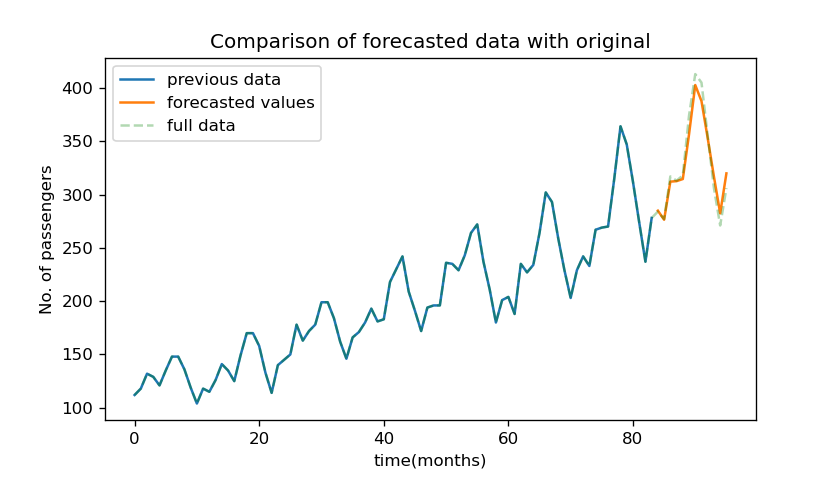

In [103]:
fig, ax = plt.subplots()
ax.plot(airlines_forecast_vis_sarima, label=['previous data','forecasted values'])
ax.plot(range(len(airlines_forecast_vis_sarima)), airlines_df2['Passengers'], 'g--', label='full data', alpha=0.3)
ax.set_xlabel('time(months)')
ax.set_ylabel('No. of passengers')
ax.set_title('Comparison of forecasted data with original')
ax.legend()
plt.show()

## 6. Final model
- Based on the above analysis, we can choose **Holt's Winter additive seasonality and multiplicative trend since it has the lowest MAPE of all models**.

### 6.1 Constructing a new dataset for the subsequent year

In [104]:
airlines_df_new = pd.DataFrame()

In [105]:
months_new = ['2003-'+ str(i)+ '-01' for i in range(1,13) ] # Generating the months

In [106]:
months_list = pd.Series(data=months_new,
                        name='Month',
                        dtype='datetime64[ns]') # Months col

In [107]:
airlines_df_new = pd.DataFrame(months_list)

In [108]:
airlines_df_new['month_name'] = airlines_df_new['Month'].dt.strftime('%b') # Extractingh month names

In [109]:
month_enc_new = pd.get_dummies(airlines_df_new['month_name']).reindex(columns=month_names) # One hot enc month names

In [110]:
airlines_df_new['year'] = airlines_df_new['Month'].dt.strftime('%Y') # Extracting years

In [111]:
t_new = np.linspace(97, 108, num=12, dtype=int) # time in months and square of time column for forecasting model
t_sq_new = t_new**2

In [112]:
time_new = {'t':t_new,
            't_square':t_sq_new}
t_new_df = pd.DataFrame(time_new, index=months_list.index)

In [113]:
airlines_df_new = pd.concat([airlines_df_new, t_new_df, month_enc_new], axis=1)

In [114]:
airlines_df_new.head() # Prepared dataframe for the subsequent year.

,Month,month_name,year,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2003-01-01,Jan,2003,97,9409,1,0,0,0,0,0,0,0,0,0,0,0
1,2003-02-01,Feb,2003,98,9604,0,1,0,0,0,0,0,0,0,0,0,0
2,2003-03-01,Mar,2003,99,9801,0,0,1,0,0,0,0,0,0,0,0,0
3,2003-04-01,Apr,2003,100,10000,0,0,0,1,0,0,0,0,0,0,0,0
4,2003-05-01,May,2003,101,10201,0,0,0,0,1,0,0,0,0,0,0,0


In [115]:
airlines_df_test = airlines_df_new.copy()

### 6.2 Fitting the final model with full dataset

In [116]:
airlines_df2.head()

,Month,Passengers,log_Passengers,month_name,year,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1995-01-01,112,4.718499,Jan,1995,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1,1995-02-01,118,4.770685,Feb,1995,2,4,0,1,0,0,0,0,0,0,0,0,0,0
2,1995-03-01,132,4.882802,Mar,1995,3,9,0,0,1,0,0,0,0,0,0,0,0,0
3,1995-04-01,129,4.859812,Apr,1995,4,16,0,0,0,1,0,0,0,0,0,0,0,0
4,1995-05-01,121,4.795791,May,1995,5,25,0,0,0,0,1,0,0,0,0,0,0,0


In [117]:
final_model = ExponentialSmoothing(airlines_df2["Passengers"],seasonal="add",trend="mul",seasonal_periods=12).fit()

In [118]:
# Predictions from t=97 to t=108 -Corresponding months for the subsequent year.
df_new = pd.Series(final_model.predict(start=97 ,end = 108), name='F_Passengers').round().astype('int').reset_index(drop=True)

In [119]:
airlines_df_test = pd.concat([airlines_df_new, df_new], axis=1)

In [120]:
airlines_df_test

,Month,month_name,year,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,F_Passengers
0,2003-01-01,Jan,2003,97,9409,1,0,0,0,0,0,0,0,0,0,0,0,317
1,2003-02-01,Feb,2003,98,9604,0,1,0,0,0,0,0,0,0,0,0,0,356
2,2003-03-01,Mar,2003,99,9801,0,0,1,0,0,0,0,0,0,0,0,0,354
3,2003-04-01,Apr,2003,100,10000,0,0,0,1,0,0,0,0,0,0,0,0,360
4,2003-05-01,May,2003,101,10201,0,0,0,0,1,0,0,0,0,0,0,0,413
5,2003-06-01,Jun,2003,102,10404,0,0,0,0,0,1,0,0,0,0,0,0,451
6,2003-07-01,Jul,2003,103,10609,0,0,0,0,0,0,1,0,0,0,0,0,440
7,2003-08-01,Aug,2003,104,10816,0,0,0,0,0,0,0,1,0,0,0,0,391
8,2003-09-01,Sep,2003,105,11025,0,0,0,0,0,0,0,0,1,0,0,0,345
9,2003-10-01,Oct,2003,106,11236,0,0,0,0,0,0,0,0,0,1,0,0,313


### 6.3 Visualizing the final predictions

In [121]:
final_forecast = pd.concat([airlines_df2, airlines_df_test], axis=0)

In [122]:
final_forecast.tail(14)

,Month,Passengers,log_Passengers,month_name,year,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,F_Passengers
94,2002-11-01,271.0,5.602119,Nov,2002,95,9025,0,0,0,0,0,0,0,0,0,0,1,0,NaN
95,2002-12-01,306.0,5.723585,Dec,2002,96,9216,0,0,0,0,0,0,0,0,0,0,0,1,NaN
0,2003-01-01,NaN,NaN,Jan,2003,97,9409,1,0,0,0,0,0,0,0,0,0,0,0,317.0
1,2003-02-01,NaN,NaN,Feb,2003,98,9604,0,1,0,0,0,0,0,0,0,0,0,0,356.0
2,2003-03-01,NaN,NaN,Mar,2003,99,9801,0,0,1,0,0,0,0,0,0,0,0,0,354.0
3,2003-04-01,NaN,NaN,Apr,2003,100,10000,0,0,0,1,0,0,0,0,0,0,0,0,360.0
4,2003-05-01,NaN,NaN,May,2003,101,10201,0,0,0,0,1,0,0,0,0,0,0,0,413.0
5,2003-06-01,NaN,NaN,Jun,2003,102,10404,0,0,0,0,0,1,0,0,0,0,0,0,451.0
6,2003-07-01,NaN,NaN,Jul,2003,103,10609,0,0,0,0,0,0,1,0,0,0,0,0,440.0
7,2003-08-01,NaN,NaN,Aug,2003,104,10816,0,0,0,0,0,0,0,1,0,0,0,0,391.0


In [123]:
final_forecast_vis = final_forecast[['Passengers', 'F_Passengers']].reset_index(drop=True)

In [124]:
final_forecast_vis.tail()

,Passengers,F_Passengers
103,NaN,391.0
104,NaN,345.0
105,NaN,313.0
106,NaN,362.0
107,NaN,369.0


<IPython.core.display.Javascript object>


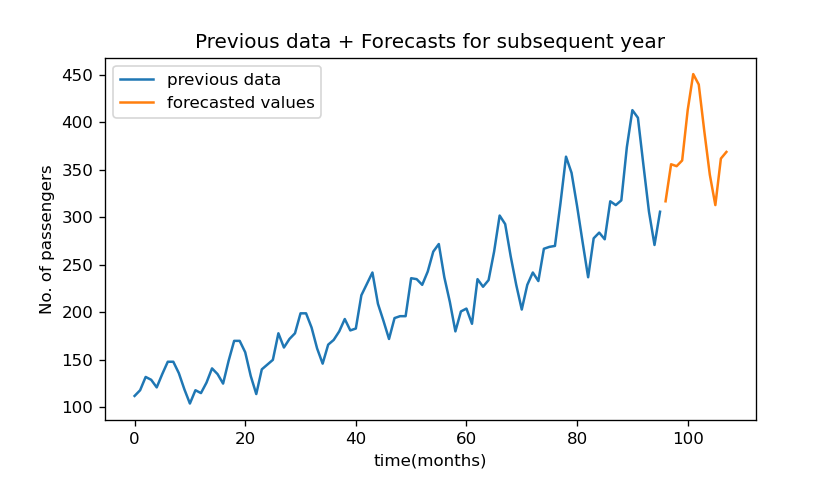

In [125]:
fig, ax = plt.subplots()
ax.plot(final_forecast_vis, label=['previous data','forecasted values'])
ax.set_xlabel('time(months)')
ax.set_ylabel('No. of passengers')
ax.set_title('Previous data + Forecasts for subsequent year')
ax.legend()
plt.show()

## 7. Conclusion:
- Different model were tried out to forecast the number of passengers for an airlines company and the **Holt's Winter additive seasonality and multiplicative trend**, had the least MAPE. This was chosen as the final model.
- **Note 1:**A total of **17 dummy variables** were created to aid in the model building process for model based forecasting.
- **Note 2:** The extra columns were added in the final data set for convenience if model based forecasting is to be used. In the present case it is not required.